In [61]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax
from jax.scipy.special import logsumexp
from tqdm.auto import tqdm

import context

from examples.PMF.pmf_model import grad_log_post
from examples.PMF.util import R_train, R_test, flatten_PMF_params, load_PMF_MAP
from examples.PMF.util import mean_rating, rmse_PMF
from examples.PMF.sgld_PMF_functions import sgld_PMF_time_budget_CV, sgld_PMF_time_budget, sgld_PMF_time_budget_svrg
from examples.PMF.adam import sgld_adam_PMF_time_budget
from examples.PMF.sghmc import run_sghmc_PMF, run_sghmc_PMF_time_budget

from ksd import imq_KSD
from util import progress_bar_scan, wait_until_computed






# PMF -  RMSE plots



In [ ]:
def get_rmse_list(samples):
    U_samples = np.array([elem[0] for elem in samples])
    V_samples = np.array([elem[1] for elem in samples])

    rmse_list = []
    num_samples = len(U_samples)

    for idx in tqdm(range(num_samples)):
        Usam = U_samples[idx][np.newaxis]
        Vsam = V_samples[idx][np.newaxis]
        rmse_list.append(rmse_PMF(Usam, Vsam, R_test, mean_rating))
    return rmse_list

## sgld

#### SH

In [27]:
time_budget = 200

key = random.PRNGKey(0)
MAP_params = load_PMF_MAP()

# use parameters from the 1st SH chain (from list_params_sgld_10`)
dt = 10**(-4.41)
batch_size = int(0.0046*R_train.shape[0])

samples_SH, _ = sgld_PMF_time_budget(key, time_budget, grad_log_post, dt, 
                                     batch_size, MAP_params, R_train, save_rate=30)

print(f"Number of samples: {len(samples_SH)*30:,}")

Number of samples: 175,260


#### default

In [39]:
key = random.PRNGKey(0)
MAP_params = load_PMF_MAP()
dt = 10**(-3.3)
batch_size = int(0.1*R_train.shape[0])
time_budget = 200.

samples_default, _ = sgld_PMF_time_budget(key, time_budget, grad_log_post, 
                                dt, batch_size, MAP_params, R_train, save_rate=30)


print(f"Number of samples: {len(samples_default)*30:,}")

Number of samples: 102,390


##### adam

In [40]:
time_budget = 200.

key = random.PRNGKey(0)
dt = 1e-3
batch_size = int(R_train.shape[0]*0.1)
params_IC = load_PMF_MAP()
samples_sgldadam, _ = sgld_adam_PMF_time_budget(key, time_budget, dt, 
                                batch_size, R_train, params_IC, save_rate=30)

print(f"Number of samples: {len(samples_sgldadam)*30:,}")

Compiling
Running
Iteration 2000. Time: 4 / 200.0 sec
Iteration 4000. Time: 8 / 200.0 sec
Iteration 6000. Time: 12 / 200.0 sec
Iteration 8000. Time: 16 / 200.0 sec
Iteration 10000. Time: 21 / 200.0 sec
Iteration 12000. Time: 25 / 200.0 sec
Iteration 14000. Time: 30 / 200.0 sec
Iteration 16000. Time: 34 / 200.0 sec
Iteration 18000. Time: 39 / 200.0 sec
Iteration 20000. Time: 43 / 200.0 sec
Iteration 22000. Time: 48 / 200.0 sec
Iteration 24000. Time: 52 / 200.0 sec
Iteration 26000. Time: 56 / 200.0 sec
Iteration 28000. Time: 60 / 200.0 sec
Iteration 30000. Time: 65 / 200.0 sec
Iteration 32000. Time: 69 / 200.0 sec
Iteration 34000. Time: 74 / 200.0 sec
Iteration 36000. Time: 78 / 200.0 sec
Iteration 38000. Time: 82 / 200.0 sec
Iteration 40000. Time: 87 / 200.0 sec
Iteration 42000. Time: 91 / 200.0 sec
Iteration 44000. Time: 95 / 200.0 sec
Iteration 46000. Time: 100 / 200.0 sec
Iteration 48000. Time: 105 / 200.0 sec
Iteration 50000. Time: 110 / 200.0 sec
Iteration 52000. Time: 115 / 200.0 

### RMSE plot

In [ ]:
rmse_list_SH = get_rmse_list(samples_SH)
rmse_list_default = get_rmse_list(samples_default)
rmse_list_adam = get_rmse_list(samples_sgldadam)


In [48]:
# np.savetxt("outputs/PMF_rmse_list/sgld/rmse_SH.txt", rmse_list_SH)
# np.savetxt("outputs/PMF_rmse_list/sgld/rmse_default.txt", rmse_list_default)
# np.savetxt("outputs/PMF_rmse_list/sgld/rmse_adam.txt", rmse_list_adam)


rmse_list_SH = np.genfromtxt("outputs/PMF_rmse_list/sgld/rmse_SH.txt")
rmse_list_default = np.genfromtxt("outputs/PMF_rmse_list/sgld/rmse_default.txt")
rmse_list_adam = np.genfromtxt("outputs/PMF_rmse_list/sgld/rmse_adam.txt")

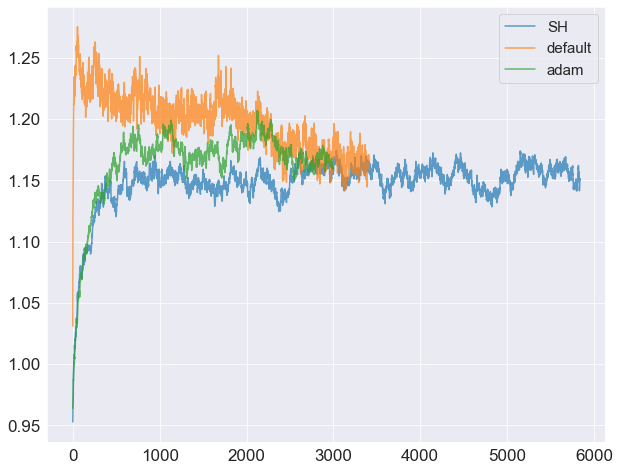

In [57]:
plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(10,8))

plt.plot(rmse_list_SH, label="SH", alpha=0.7)
plt.plot(rmse_list_default, label="default", alpha=0.7)
plt.plot(rmse_list_adam, label="adam", alpha=0.7)

plt.legend(fontsize=15)


## svrg

In [51]:
key = random.PRNGKey(0)

# use parameters from the 1st SH chain (from list_params_sgld_10`)
dt = 10**(-5.063)
batch_size = int(0.0085*R_train.shape[0])
time_budget = 200.
update_rate = 9213

samples_svrg_SH, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                               batch_size, load_PMF_MAP(), R_train, update_rate, save_rate=30)


print(f"Number of samples: {len(samples_svrg_SH)*30:,}")

Number of samples: 92,490


In [52]:
key = random.PRNGKey(0)

dt = 10**(-4.)
batch_size = int(0.1*R_train.shape[0])
update_rate = 2001

samples_svrg_default, _ = sgld_PMF_time_budget_svrg(key, time_budget, grad_log_post, dt, 
                               batch_size, load_PMF_MAP(), R_train, update_rate, save_rate=30)


print(f"Number of samples: {len(samples_svrg_default)*30:,}")


Number of samples: 51,180


In [53]:
rmse_list_svrg_SH = get_rmse_list(samples_svrg_SH)
rmse_list_svrg_default = get_rmse_list(samples_svrg_default)


In [55]:
# np.savetxt("outputs/PMF_rmse_list/svrg/rmse_SH.txt", rmse_list_svrg_SH)
# np.savetxt("outputs/PMF_rmse_list/svrg/rmse_default.txt", rmse_list_svrg_default)


rmse_list_svrg_SH = np.genfromtxt("outputs/PMF_rmse_list/svrg/rmse_SH.txt")
rmse_list_svrg_default = np.genfromtxt("outputs/PMF_rmse_list/svrg/rmse_default.txt")


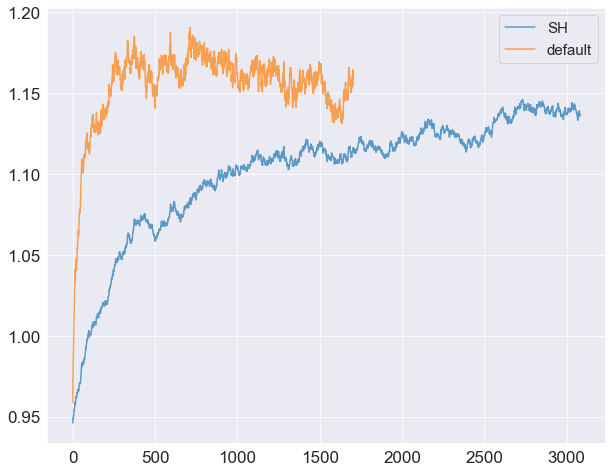

In [58]:
plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(10,8))

plt.plot(rmse_list_svrg_SH, label="SH", alpha=0.7)
plt.plot(rmse_list_svrg_default, label="default", alpha=0.7)

plt.legend(fontsize=15)


## sghmc

In [80]:
key = random.PRNGKey(0)

# use parameters from the 1st SH chain (from list_params_sghmc_30`)
dt = 10**(-5.34)
batch_size = int(0.081*R_train.shape[0])
time_budget = 500.
L = 3

samples_sghmc_SH, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                     L, R_train, load_PMF_MAP(), save_rate=50)


print(f"Number of samples: {len(samples_sghmc_SH)*50:,}")

Iteration 1000. Time: 5 / 500.0 sec
Iteration 2000. Time: 11 / 500.0 sec
Iteration 3000. Time: 16 / 500.0 sec
Iteration 4000. Time: 22 / 500.0 sec
Iteration 5000. Time: 27 / 500.0 sec
Iteration 6000. Time: 33 / 500.0 sec
Iteration 7000. Time: 43 / 500.0 sec
Iteration 8000. Time: 51 / 500.0 sec
Iteration 9000. Time: 56 / 500.0 sec
Iteration 10000. Time: 64 / 500.0 sec
Iteration 11000. Time: 72 / 500.0 sec
Iteration 12000. Time: 78 / 500.0 sec
Iteration 13000. Time: 85 / 500.0 sec
Iteration 14000. Time: 91 / 500.0 sec
Iteration 15000. Time: 97 / 500.0 sec
Iteration 16000. Time: 103 / 500.0 sec
Iteration 17000. Time: 109 / 500.0 sec
Iteration 18000. Time: 115 / 500.0 sec
Iteration 19000. Time: 120 / 500.0 sec
Iteration 20000. Time: 126 / 500.0 sec
Iteration 21000. Time: 132 / 500.0 sec
Iteration 22000. Time: 137 / 500.0 sec
Iteration 23000. Time: 143 / 500.0 sec
Iteration 24000. Time: 149 / 500.0 sec
Iteration 25000. Time: 154 / 500.0 sec
Iteration 26000. Time: 160 / 500.0 sec
Iteration 2

In [81]:
key = random.PRNGKey(0)

dt = 10**(-5)
batch_size = int(0.1*R_train.shape[0])
time_budget = 500.
L = 26

samples_sghmc_default, _ = run_sghmc_PMF_time_budget(key, time_budget, dt, batch_size, 
                                     L, R_train, load_PMF_MAP(), save_rate=50)


print(f"Number of samples: {len(samples_sghmc_default)*50:,}")

Iteration 1000. Time: 45 / 500.0 sec
Iteration 2000. Time: 90 / 500.0 sec
Iteration 3000. Time: 135 / 500.0 sec
Iteration 4000. Time: 186 / 500.0 sec
Iteration 5000. Time: 239 / 500.0 sec
Iteration 6000. Time: 293 / 500.0 sec
Iteration 7000. Time: 345 / 500.0 sec
Iteration 8000. Time: 396 / 500.0 sec
Iteration 9000. Time: 447 / 500.0 sec
Iteration 10000. Time: 495 / 500.0 sec
Number of samples: 10,050


In [82]:
rmse_list_sghmc_SH = get_rmse_list(samples_sghmc_SH)
rmse_list_sghmc_default = get_rmse_list(samples_sghmc_default)



In [83]:
# np.savetxt("outputs/PMF_rmse_list/sghmc/rmse_SH.txt", rmse_list_sghmc_SH)
# np.savetxt("outputs/PMF_rmse_list/sghmc/rmse_default.txt", rmse_list_sghmc_default)


# rmse_list_sghmc_SH = np.genfromtxt("outputs/PMF_rmse_list/sghmc/rmse_SH.txt")
# rmse_list_sghmc_default = np.genfromtxt("outputs/PMF_rmse_list/sghmc/rmse_default.txt")


## 3 plots

In [93]:
rmse_list_SH = np.genfromtxt("outputs/PMF_rmse_list/sgld/rmse_SH.txt")
rmse_list_default = np.genfromtxt("outputs/PMF_rmse_list/sgld/rmse_default.txt")
rmse_list_adam = np.genfromtxt("outputs/PMF_rmse_list/sgld/rmse_adam.txt")


rmse_list_svrg_SH = np.genfromtxt("outputs/PMF_rmse_list/svrg/rmse_SH.txt")
rmse_list_svrg_default = np.genfromtxt("outputs/PMF_rmse_list/svrg/rmse_default.txt")


rmse_list_sghmc_SH = np.genfromtxt("outputs/PMF_rmse_list/sghmc/rmse_SH.txt")
rmse_list_sghmc_default = np.genfromtxt("outputs/PMF_rmse_list/sghmc/rmse_default.txt")


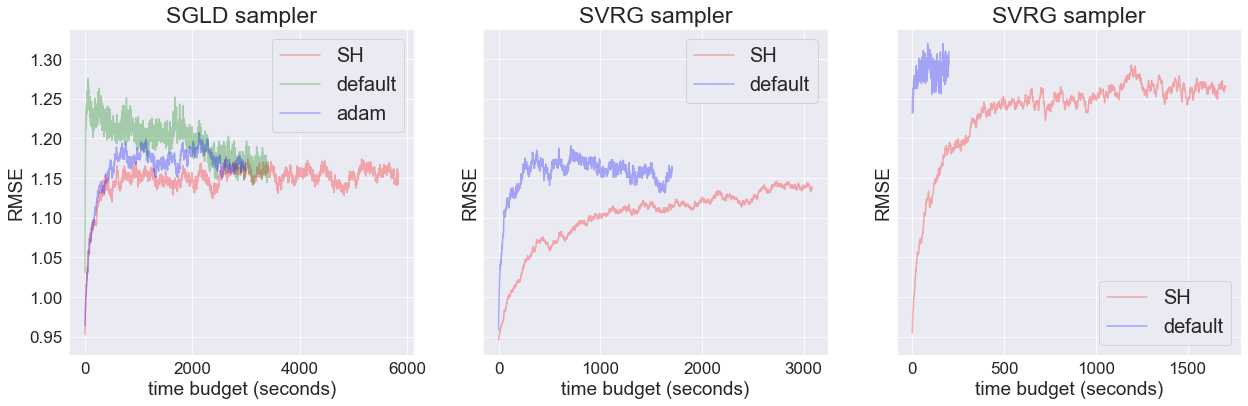

In [99]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6), sharey=True)

time_range = np.arange(0,200)
# ===============
# SGLD

ax[0].plot(rmse_list_SH, c='r', label="SH", alpha=0.3)
ax[0].plot(rmse_list_default, c='g', label="default", alpha=0.3)
ax[0].plot(rmse_list_adam, c='b', label="adam", alpha=0.3)

ax[0].set_title("SGLD sampler", size=23)
ax[0].set_ylabel("RMSE", size=19)
ax[0].set_xlabel("time budget (seconds)", size=19)
ax[0].legend(fontsize=20)



# ===============
# SVRG

ax[1].plot(rmse_list_svrg_SH, c='r', label="SH", alpha=0.3)
ax[1].plot(rmse_list_svrg_default, c='b', label="default", alpha=0.3)

ax[1].set_title("SVRG sampler", size=23)
ax[1].set_ylabel("RMSE", size=19)
ax[1].set_xlabel("time budget (seconds)", size=19)
ax[1].legend(fontsize=20)


# ==================
# SG-HMC

ax[2].plot(rmse_list_sghmc_SH, c='r', label="SH", alpha=0.3)
ax[2].plot(rmse_list_sghmc_default, c='b', label="default", alpha=0.3)

ax[2].set_title("SVRG sampler", size=23)
ax[2].set_ylabel("RMSE", size=19)
ax[2].set_xlabel("time budget (seconds)", size=19)
ax[2].legend(fontsize=20)

# plt.savefig("images/PMF_RMSE_curves.png")

